In [2]:
# Configure workspace
import os
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep = '\n')

Found the config file in: /Users/jamescarpinter/depot/readydemo/config.json
contosomanufacturing
scottgu-all-hands
eastus2
2a779d6f-0806-4359-a6e8-f1fd57bb5dd7


In [3]:
# Setup compute
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your GPU cluster
cluster_name = "gpucluster"

# Verify that cluster does not exist already
try:
    gpu_cluster = ComputeTarget(workspace = ws, name = cluster_name)
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6',
                                                           min_nodes=0,
                                                           max_nodes=4)
    gpu_cluster = ComputeTarget.create(ws, cluster_name, compute_config)

gpu_cluster.wait_for_completion(show_output=True)

Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


In [4]:
# Configure experiment
from azureml.core import Experiment

experiment_name = 'hard-hat'
exp = Experiment(workspace=ws, name=experiment_name)

In [5]:
# Prepare data
ds = ws.get_default_datastore()
ds.upload('./data')

Target already exists. Skipping upload for val.record-00005-of-00010
Target already exists. Skipping upload for val.record-00004-of-00010
Target already exists. Skipping upload for model.ckpt.meta
Target already exists. Skipping upload for train.record-00009-of-00010
Target already exists. Skipping upload for train.record-00008-of-00010
Target already exists. Skipping upload for train.record-00003-of-00010
Target already exists. Skipping upload for train.record-00002-of-00010
Target already exists. Skipping upload for label_map.pbtxt
Target already exists. Skipping upload for .gitkeep
Target already exists. Skipping upload for val.record-00002-of-00010
Target already exists. Skipping upload for val.record-00003-of-00010
Target already exists. Skipping upload for val.record-00008-of-00010
Target already exists. Skipping upload for val.record-00009-of-00010
Target already exists. Skipping upload for train.record-00004-of-00010
Target already exists. Skipping upload for train.record-00005

$AZUREML_DATAREFERENCE_workspaceblobstore

In [6]:
# Submit the experiment
os.chdir('./train')

from azureml.core import Run
from azureml.train.dnn import TensorFlow
from azureml.core.runconfig import AzureContainerRegistry, DockerEnvironment, EnvironmentDefinition, PythonEnvironment

registry = AzureContainerRegistry()
registry.address = 'contosomanufac5523805767.azurecr.io'
registry.username = 'contosomanufac5523805767'
registry.password = 'RC+cx6OiEhgK8MY1rSGkkaj8eYnGncNC'

docker_config = DockerEnvironment()
docker_config.enabled = True
docker_config.base_image = 'contosoml/base-gpu:0.2.1'
docker_config.base_image_registry = registry
docker_config.gpu_support = True

python_config = PythonEnvironment()
python_config.user_managed_dependencies = True

env_def = EnvironmentDefinition()
env_def.docker = docker_config
env_def.python = python_config

script_params = {
    '--model_dir': './outputs',
    '--pipeline_config_path': './faster_rcnn_resnet101_hardhats.config'
}

tf_est = TensorFlow(source_directory = './src',
                    script_params=script_params,
                    compute_target=gpu_cluster,
                    entry_script='train.py',
                    inputs=[ds.as_download(path_on_compute='/data')],
                    environment_definition=env_def)
run = exp.submit(tf_est)

os.chdir('..')

run

Experiment,Id,Type,Status,Details Page,Docs Page
hard-hat,hard-hat_1549667969_34884894,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


In [ ]:
run.wait_for_completion(show_output=True)

In [7]:
# Prepare model
from azureml.core.model import Model
from azureml.core.run import Run

# Register the model for deployment
model = Model.register(model_path = "./models/frozen_inference_graph.pb",
                       model_name = "frozen_inference_graph.pb",
                       description = "Contoso Manufacturing model",
                       workspace = ws)

Registering model frozen_inference_graph.pb


In [8]:
# Create an AKS cluster
from azureml.core.compute import AksCompute, ComputeTarget
aks_cluster_name = 'contoso-aks'

# Use the default configuration (can also provide parameters to customize)
prov_config = AksCompute.provisioning_configuration(location='eastus2')

# Create the cluster
aks_target = ComputeTarget.create(workspace=ws, 
                                  name=aks_cluster_name, 
                                  provisioning_configuration=prov_config)

aks_target.wait_for_completion(True)

SucceededProvisioning operation finished, operation "Succeeded"


In [9]:
# Create a container image
os.chdir('./score')

from azureml.core.model import Model
from azureml.core.image import ContainerImage

model = Model.list(ws, name='frozen_inference_graph.pb')[0]

image_config = ContainerImage.image_configuration(execution_script='score.py',
                                                  runtime='python',
                                                  conda_file='score.yml',
                                                  description='Object detection model')

image = ContainerImage.create(name='contosoimage',
                              models=[model],
                              image_config=image_config,
                              workspace=ws)

os.chdir('..')

image

Creating image


ContainerImage(workspace=<azureml.core.workspace.Workspace object at 0x12018f898>, name=contosoimage, id=contosoimage:18, tags={}, properties={}, version=18)

In [ ]:
image.wait_for_creation(show_output = True)

In [10]:
# Deploy the model as a service
from azureml.core.webservice import Webservice, AksWebservice

image = next((x for x in ContainerImage.list(ws, image_name='contosoimage') if x.creation_state == 'Succeeded'), None)

aks_service_name = 'contosoman'
aks_config = AksWebservice.deploy_configuration(collect_model_data=True, enable_app_insights=True)
aks_service = Webservice.deploy_from_image(workspace=ws, 
                                           name=aks_service_name,
                                           image=image,
                                           deployment_config=aks_config,
                                           deployment_target=aks_target)
aks_service

Creating service


In [ ]:
aks_service.wait_for_deployment(show_output=True)

In [11]:
# Test the service
os.chdir('./score')

import requests
from azureml.core.webservice import Webservice, AksWebservice

image = open('./samples/Before.jpg', 'rb')
input_data = image.read()
image.close()

aks_service_name = 'contosoman2'
aks_service = AksWebservice(workspace=ws, name=aks_service_name)

auth = 'Bearer ' + aks_service.get_keys()[0]
uri = aks_service.scoring_uri

res = requests.post(url=uri,
                    data=input_data,
                    headers={'Authorization': auth, 'Content-Type': 'application/octet-stream'})

results = res.json()

os.chdir('..')

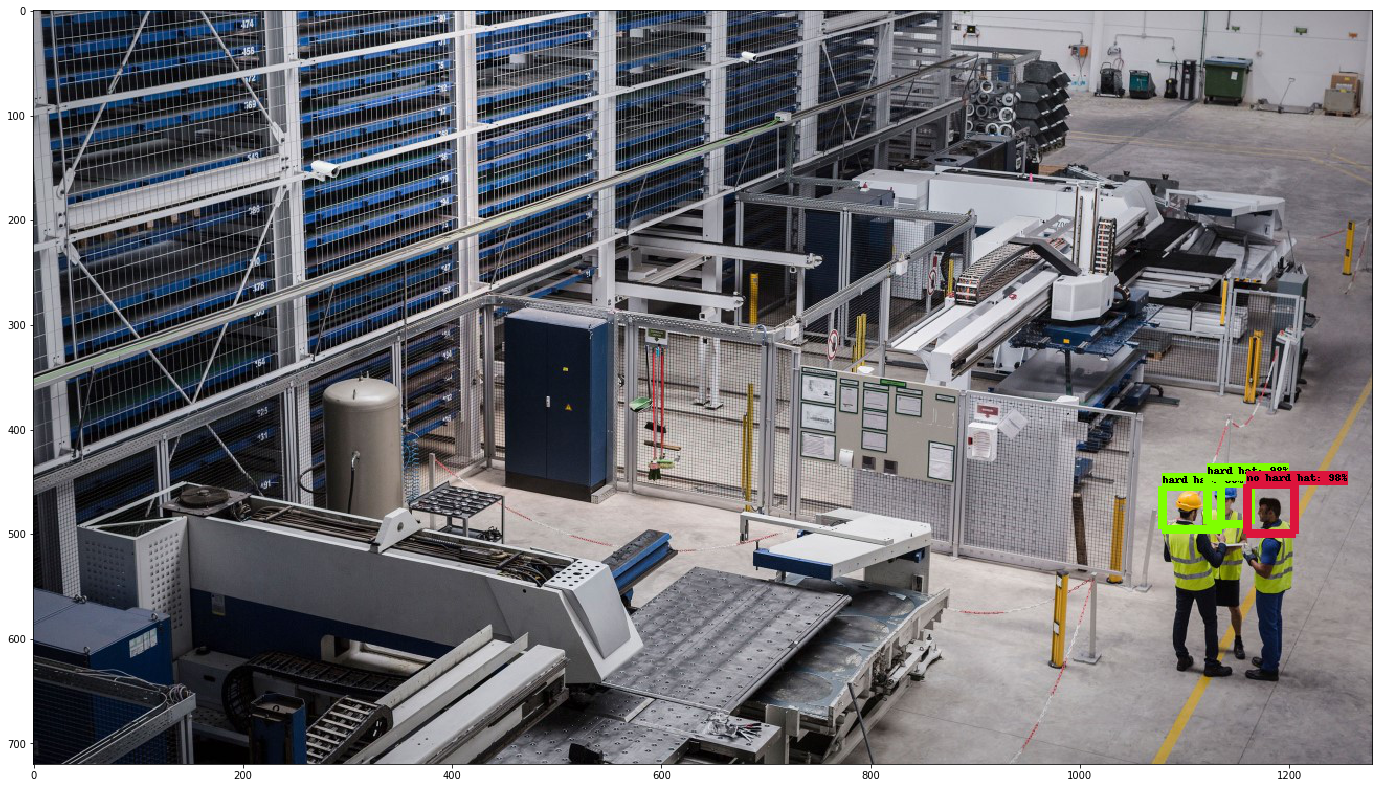

In [13]:
# Show the results
os.chdir('./score')

import utils
import numpy as np

from matplotlib import pyplot as plt
from PIL import Image

image = Image.open('./samples/Before.jpg')
image_np = utils.load_image_into_numpy_array(image)
category_index = utils.create_category_index_from_labelmap('./samples/label_map.pbtxt', use_display_name=True)

utils.visualize_boxes_and_labels_on_image_array(
    image_np,
    np.array(results['detection_boxes']),
    np.array(results['detection_classes']),
    np.array(results['detection_scores']),
    category_index,
    instance_masks=results.get('detection_masks'),
    use_normalized_coordinates=True,
    line_thickness=8)

os.chdir('..')

plt.figure(figsize=(24, 16))
plt.imshow(image_np)

In [17]:
# Build container image
os.chdir('./score-edge/src')

from azureml.core.image import Image
from azureml.contrib.iot import IotContainerImage

image_config = IotContainerImage.image_configuration(
                                 architecture='arm32v7',
                                 execution_script='main.py',
                                 dependencies=['camera.py','iot.py','ipcprovider.py','utility.py','frame_iterators.py'],
                                 docker_file='Dockerfile',
                                 description='Object detection model (Edge)')

image = Image.create(name = 'contosoimage-edge',
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

os.chdir('../..')

image

Creating image


IotContainerImage(workspace=<azureml.core.workspace.Workspace object at 0x12018f898>, name=contosoimage-edge, id=contosoimage-edge:3, tags={}, properties={}, version=3)

In [ ]:
image.wait_for_creation(show_output = True)